# Numerical Analysis

The goal of this lecture is to give an introduction to the sometimes surprising results of **numerical analysis**, which we can briefly define as follows:

* In pure math, we find answers (or prove they exist) and prove that they are correct.
* Computer science is basically *math + time*: we also want to know how *quickly* we can compute something.  (Hence, by the well-known theorem that time is money, computer science is *math + money*.)
* Numerical analysis is **math + time + accuracy**: we want to compute a result quickly but *approximately*, and want to make the error as small as possible as quickly as possible.

Numerical analysis encompasses a huge variety of problems and algorithms.  Today, we will try to get a *flavor* of these problems, to see that sometimes there are *non-obvious methods* that can give amazing results.   If you care about *any kind of computation involving "continuous" numbers* and approximations, you should **go take a numerical-analysis/methods course**.

In [1]:
using BenchmarkTools, PyPlot, Interact # some useful packages

# Floating-point arithmetic

Most commonly, [floating-point arithmetic](https://en.wikipedia.org/wiki/Floating_point) is used to represent non-integer values on a computer.  Floating-point numbers are just a **subset of the rational numbers**, of a form familiar from scientific notation:
$$
1.2345 = \underbrace{12345}_\text{significand} \times \underbrace{10}_\text{base}^{\overbrace{-4}^\text{exponent}}.
$$
That is, you have a **significand** with some number of digits (the *precision*) in some **base**, multiplied by the base to some **exponent**.   This allows you to represent a wide range of real numbers with a bounded **relative error** (fractional error).

All modern CPUs implement floating-point arithmetic in hardware, with a catch: they use **binary** (base-2) floating-point numbers (following the [IEEE 754 standard](https://en.wikipedia.org/wiki/IEEE_floating_point)), which are of the form:

$$
\underbrace{\pm}_\text{sign}\underbrace{d_1.d_2d_3d_4\cdots d_p}_\text{significand} \times \underbrace{2}_\text{base}^{\text{exponent}}.
$$

where the $d_k$ are *base-2 digits* (0 or 1), and $p$ is the precision.  `Float64` corresponds to a **53-bit precision**, or *about 15 decimal digits*.  This significand, along with the exponent and sign bits, are packed cleverly into 64 bits. `Float32` corresponds to **24-bit precision**, or about *7 decimal digits*.

In [2]:
significand(3.14159), exponent(3.14159), precision(Float64)

(1.570795,1,53)

In [3]:
1.570795 * 2^1

3.14159

The thing to keep in mind is that floating-point arithmetic **rounds every input** and the **result of every +,-,×,/ operation** to the **closest floating-point value** ("correct rounding").  If an input or operation *can* be represented exactly, then it *will* be exact.

For example, integers and integer arithmetic (up to $2^p$) are **exact** in floating-point arithmetic, contrary to popular misconception, as are integers **multiplied by powers of 2** for **binary** floating point:

In [4]:
2 + 1012344 - 123461234

-122448888

In [5]:
2 - 0.5 + 0.25

1.75

However, there are lots of numbers that cannot be represented exactly, and in particular **most decimal fractions are rounded**.

In [6]:
1.1 - (2 - 0.8 - 0.1)

2.220446049250313e-16

In [7]:
1.1, 2 - 0.8 - 0.1

(1.1,1.0999999999999999)

The **fractional distance between adjacent floating-point values** is called the **epsilon** value (also, confusingly, called the **precision**):

In [8]:
eps(Float64)

2.220446049250313e-16

This is an upper bound on the relative error of a *single* rounding operation (e.g. converting a single real input to floating-point, or the error of a single arithmetic operation).  However, **rounding errors can accumulate** over the course of many operations, so the eventual error can be much larger than this.

Besides `Float32` and `Float64`, Julia also comes with a `BigFloat` type that represents an [arbitrary precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) binary floating-point value.   The precision defaults to 256 bits, but you can increase it to anything you want (limited only by memory).  Of course, it is *much* slower to do `BigFloat` arithmetic than to work with the hardware floating-point types.

By converting a `Float64` value to `BigFloat`, we can see what it "really" is, because `BigFloat` will print more digits:

In [9]:
BigFloat(1.1)

1.100000000000000088817841970012523233890533447265625000000000000000000000000000

In [10]:
precision(BigFloat)

256

In [11]:
setprecision(BigFloat, 1024) # change to 1024 bits, about 300 decimal digits
eps(BigFloat)

1.112536929253600691545116358666202032109607990231165915276663708443602217406959097927141579506255510282033669865517905502576217080776730054428006192688859410565388996766001165239805073721291818035960782523471251867104187625403325308329079474360245589984295819824250317954385059152437399890443876874974725790226e-308

In [12]:
BigFloat(1.1)

1.100000000000000088817841970012523233890533447265625000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

The constant `pi` in Julia is of a special `Irrational` type that *expands to match* the precision of any number it is combined with or converted to:

In [13]:
pi

π = 3.1415926535897...

In [14]:
BigFloat(pi) # get pi to 300 digits

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

In [15]:
BigFloat(2 - 0.8 - 0.1)

1.099999999999999866773237044981215149164199829101562500000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [16]:
BigFloat(2 - 0.5 + 0.25)

1.750000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Even `BigFloat` is binary floating point, so it cannot represent most decimal inputs exactly.  In some applications, e.g. banking, it is imperative to represent *human inputs exactly*.

For this, you can use [decimal floating point](https://en.wikipedia.org/wiki/Decimal_floating_point), which is the same floating-point concept but in **base 10**.   This is *much slower* than binary floating point because it is typically implemented *only in software*.  In Julia, a decimal floating-point implementation is provided by the [DecFP package](https://github.com/stevengj/DecFP.jl).

In [17]:
# Pkg.add("DecFP")
using DecFP

In [18]:
d64"3.14159"

+314159E-5

In [19]:
d64"1.1" == 2 - d64"0.8" - d64"0.1"

true

In [20]:
d64"1.1", 2 - d64"0.8" - d64"0.1"

(+11E-1,+11E-1)

In [21]:
x = rand(10000)
@benchmark sum($x)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     9
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  0.00 bytes
  allocs estimate:  0
  minimum time:     2.19 μs (0.00% GC)
  median time:      2.32 μs (0.00% GC)
  mean time:        2.46 μs (0.00% GC)
  maximum time:     10.22 μs (0.00% GC)

In [22]:
@benchmark sum($(Dec64.(x)))

BenchmarkTools.Trial: 
  samples:          4831
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  0.00 bytes
  allocs estimate:  0
  minimum time:     950.73 μs (0.00% GC)
  median time:      953.89 μs (0.00% GC)
  mean time:        1.03 ms (0.00% GC)
  maximum time:     2.16 ms (0.00% GC)

## Cancellation problems

Just because individual floating-point operations are rounded to precision ε, that doesn't mean that we will get the final answer to 15 digits.   Errors can accumulate over the course of several operations.

Worse, you can sometimes have [numerically unstable](https://en.wikipedia.org/wiki/Numerical_stability) algorithms that *drastically amplify small rounding errors*.   In such cases, however, one can sometimes cleverly redesign the algorithm to get accurate results.

One common problem is a [catastrophic cancellation](https://en.wikipedia.org/wiki/Loss_of_significance) error: if you *subtract two nearly equal* numbers, then the difference *eliminates most of the significant digits*.  The result can have a much larger relative error — in fact, sometimes you can lose *all* the significant digits, and get a *zero* result when it should be a small value:

In [23]:
exp(1e-20) - 1

0.0

Since $e^x - 1$ expressions come up so often, Julia's standard library (like many math libraries) provides the [special function](https://en.wikipedia.org/wiki/Special_functions) `expm1(x)` that computes it accurately.  (Obviously, `expm1(x) = exp(x) - 1` would not work.  *Exercise: implement an accurate* `expm1` function yourself.)

In [24]:
expm1(1e-20)

1.0e-20

Another great example occurs when finding the roots of a quadratic $x^2 - 2bx + c$: $x = b \pm \sqrt{b^2 - c}$.   What if $c \ll 1$?

In [25]:
b = 1.0; c = 1e-17
b + sqrt(b^2 - c), b - sqrt(b^2 - c)

(2.0,0.0)

In [26]:
b + sqrt(b^2 - c), b - sqrt(b^2 - big(c))

(2.0,5.000000000000000370212120273109624393700882290164429127864592207523389014478155316687217917901025978850301698695142546219571553358667342154457748569333498765005417133960586949251975822104801747272189758268628953361503477877159494448636805087984685664488905116315881367913923819489072681438019578785780380714837e-18)

Alternatively, we can write the second solution as
$$
x = b - \sqrt{b^2 - c} = (b - \sqrt{b^2 - c}) \frac{b + \sqrt{b^2 - c}}{b + \sqrt{b^2 - c}} = \frac{c}{b + \sqrt{b^2 - c}}
$$

In [27]:
b + sqrt(b^2 - c), c / (b + sqrt(b^2 - c))

(2.0,5.0e-18)

## Error accumulation in summation

A classic example of error accumulation is *summation*: if we sum $n$ values, how does the roundoff error grow with $n$?  The answer turns out to depend sensitively on the *order* in which we sum the values.

A famous paper on this topic is Nick Higham, ["The accuracy of floating point summation"](http://epubs.siam.org/doi/abs/10.1137/0914050), *SIAM Journal on Scientific Computing* 14, pp. 783–799, (1993).  Julia's built-in `sum` function implements an algorithm called [pairwise summation](https://en.wikipedia.org/wiki/Pairwise_summation), which is the same cost as a naive in-order sum but is much more accurate.

Let's try a couple of different ways to sum and plot the error vs. $n$.  We'll do the sum in `Float32` arithmetic, and compute the "exact" result in `Float64` arithmetic:

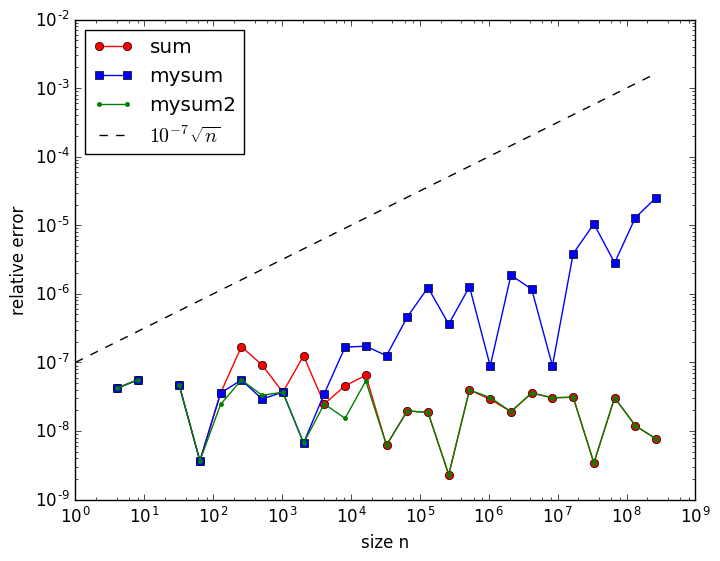

PyObject <matplotlib.text.Text object at 0x328b43e90>

In [28]:
# naive, in-order summation
function mysum(X)
    s = zero(eltype(X))
    @simd for x in X
        s += x
    end
    return s
end

# pairwise summation: recursively sum the first and second half of the array,
# until we reach a sufficiently small base case (and then just sum in order)
function mysum2(X::AbstractVector)
    if length(X) < 32
        return mysum(X)
    else
        n2 = length(X) ÷ 2
        return mysum2(view(X, 1:n2)) + mysum2(view(X, n2+1:length(X)))
    end
end

N = 2 .^ (0:28)
err_sum = Float64[]
err_mysum = Float64[]
err_mysum2 = Float64[]
for n in N
    x = rand(Float32, n)
    exact = sum(Float64.(x))
    push!(err_sum, abs(sum(x)-exact)/exact)
    push!(err_mysum, abs(mysum(x)-exact)/exact)
    push!(err_mysum2, abs(mysum2(x)-exact)/exact)
end
loglog(N, err_sum, "ro-")
loglog(N, err_mysum, "bs-")
loglog(N, err_mysum2, "g.-")
plot(N, sqrt.(N) * 1e-7, "k--")
legend(["sum","mysum","mysum2",L"10^{-7}\sqrt{n}"], loc="upper left")
xlabel("size n")
ylabel("relative error")

In [29]:
x = rand(10^6)
@time mysum(x)
@time mysum2(x) # allocations of views kills performance
@time sum(x)

  0.011856 seconds (4.70 k allocations: 211.191 KB)
  0.071376 seconds (116.70 k allocations: 5.350 MB, 8.50% gc time)
  0.000532 seconds (5 allocations: 176 bytes)


500233.9464184267

# Interpolation and quadrature

A great example of numerical analysis leading to non-obvious algorithms is [numerical integration](https://en.wikipedia.org/wiki/Numerical_integration), also known as **quadrature**.  This is an example of a problem where *clever algorithms do exponentially better than naive algorithms*.

More generally, the problem of numerical integration turns out to be closely related to that of **polynomial interpolation**, since the most common methods of doing numerical integrals is to *fit points to polynomials* (since integrating polynomials analytically is easy).

For some of the theory behind this section, see e.g. [SGJ's notes on the convergence of the trapezoidal rule and Clenshaw–Curtis quadrature](http://math.mit.edu/~stevenj/trap-iap-2011.pdf).

Let's compute $\int_{-1}^1 f(x) dx$ for some function $f(x)$ that we can't integrate analytically, e.g. $f(x) = \sin(3x + \cos(5x))$:

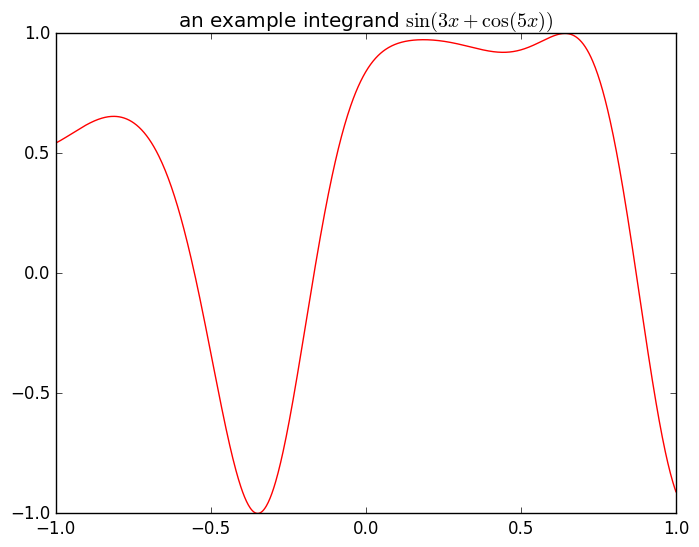

PyObject <matplotlib.text.Text object at 0x328d90f10>

In [30]:
x = linspace(-1,1,1000)
f(x) = sin(4x + cos(5x))
plot(x, f.(x), "r-")
title(L"an example integrand $\sin(3x + \cos(5x))$")

There is a built-in function `quadgk` (for "Gauss–Kronrod quadrature") to do this (although in Julia 0.6 this is split out into a separate [QuadGK module](https://github.com/JuliaMath/QuadGK.jl)), which returns a tuple `(estimated integral, estimated error)`:

In [31]:
quadgk(f, -1, 1, reltol=1e-14)

(0.7841369931808355,1.3071141391485241e-15)

Let's see at what points it evaluates our function to get, say, 8 decimal places:

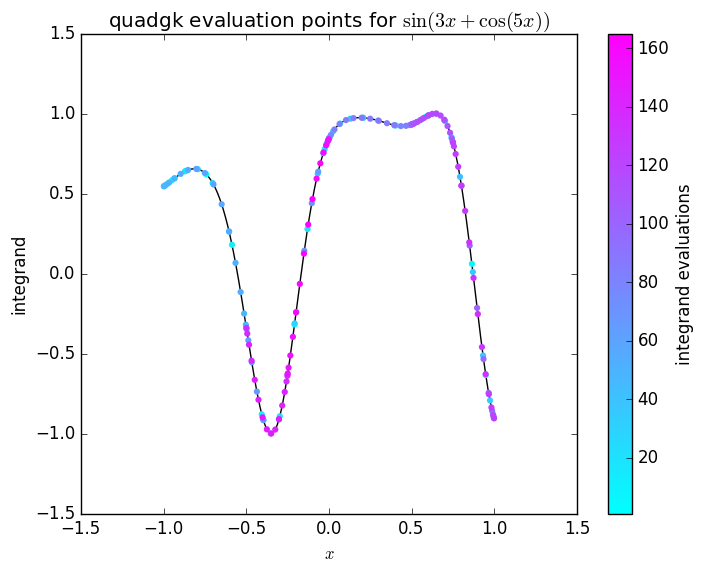

PyObject <matplotlib.text.Text object at 0x328e1da50>

In [32]:
x = linspace(-1,1,1000)
x_quadgk = Float64[]
quadgk(x -> f(push!(x_quadgk, x)[end]), -1, 1, reltol=1e-8)
plot(x, f.(x), "k-")
scatter(x_quadgk, f.(x_quadgk), c=1:length(x_quadgk), cmap="cool", linewidths=0, zorder=3)
colorbar(label="integrand evaluations")
xlabel(L"x")
ylabel("integrand")
title(L"quadgk evaluation points for $\sin(3x + \cos(5x))$")

The `quadgk` function is *adaptive*: it puts more points where it decides the function is changing more rapidly.

How might we implement our own numerical-integration ("quadrature") routine?  If you knew nothing about numerical analysis, you might think to use the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule): just evaluate the integrand at $n$ points, interpolate the function linearly, and then add up the area of the resulting trapezoids.  Like this:

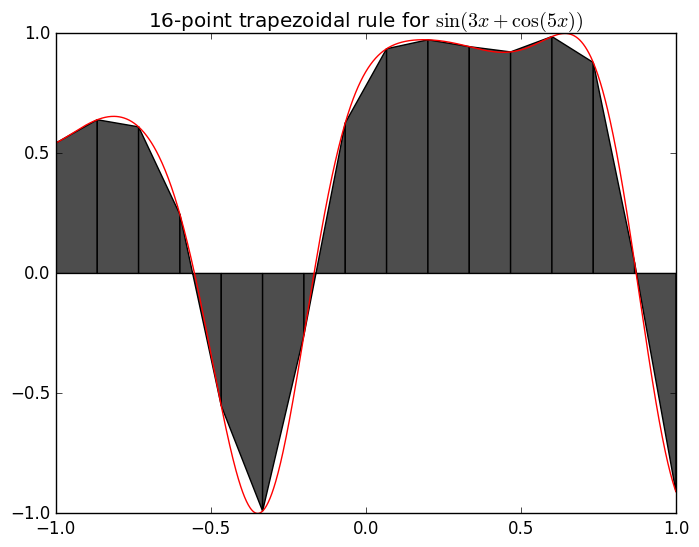

PyObject <matplotlib.text.Text object at 0x328a10710>

In [33]:
x = linspace(-1,1,1000)
n = 15
dx = 2 / n
for i = 0:n-1
    x0 = -1 + i*dx
    x1 = x0 + dx
    fill([x0,x0,x1,x1],[0,f.(x0),f.(x1),0], facecolor=(0.3,0.3,0.3))
end
plot(x, f.(x), "r-")
title(L"16-point trapezoidal rule for $\sin(3x + \cos(5x))$")

In [34]:
function trapezoidal(f, a, b, n)
    dx = (b-a)/n
    s = (f(a)+f(b))/2
    for i = 1:n-1
        s += f(a + i*dx)
    end
    return s * dx
end

trapezoidal (generic function with 1 method)

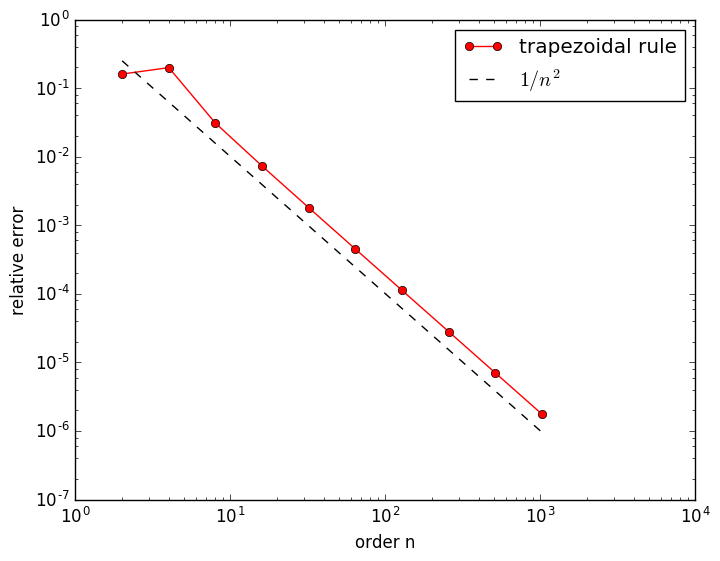

PyObject <matplotlib.text.Text object at 0x328a4f6d0>

In [35]:
exact = quadgk(f, -1, 1, reltol=1e-14)[1]
N = 2 .^ (1:10)
trap_err = Float64[]
for n in N
    push!(trap_err, abs(trapezoidal(f, -1, 1, n) - exact) / exact)
end
loglog(N, trap_err, "ro-")
loglog(N, N.^-2.0, "k--")
legend(["trapezoidal rule", L"1/n^2"], loc="upper right")
xlabel("order n")
ylabel("relative error")

One thing that might occur to you is that we could do better than linear interpolation between pairs of points.  We could use *all* the points, and fit them (exactly) to a polynomial.  This is called the [Lagrange interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial).

Integrating polynomials is easy (given the coefficients), so in principle we could keep increasing the number of points and integrate the interpolation polynomial.  This strategy is called a [Newton–Cotes rule](https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas), in fact.

Let's write a function that, given vectors `X` and `Y` of `(x,y)` values, computes the Lagrange interpolating polynomial at a point `x`.  We will use the [barycentric interpolation formula](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) to compute this in a nice way, given a set of weights computed from `X` using the function `bary(X)`.

In [36]:
function baryweights{T}(X::AbstractVector{T})
    n = length(X)
    B = ones(float(T), n)
    for j = 1:n
        for k = 1:n
            if j != k
                B[j] *= X[j] - X[k]
            end
        end
        B[j] = inv(B[j])
    end
    return B
end

lagrange(X, Y, x, B = baryweights(X)) = prod(x - X for X in X) * sum(B[j]*Y[j]/(x-X[j]) for j=1:length(X))

lagrange (generic function with 2 methods)

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"",1,1:100,"horizontal",true,"d",true)

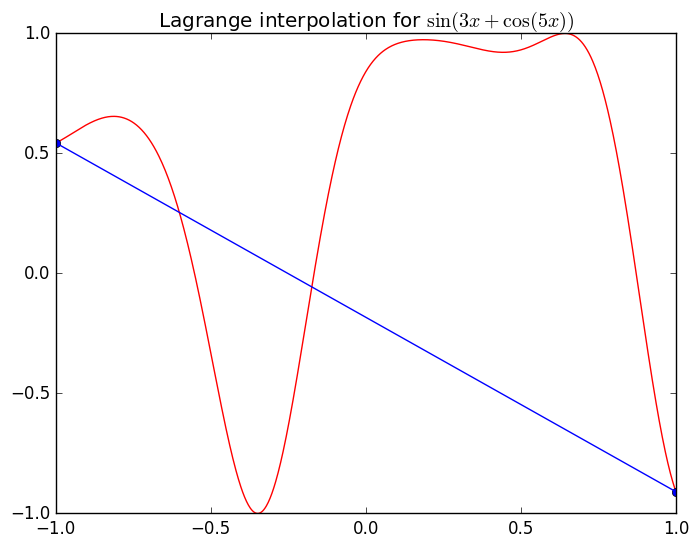

In [37]:
fig = figure()
x = linspace(-1,1,1000)

@manipulate for n in slider(1:100, value=1)
    withfig(fig) do
        plot(x, f.(x), "r-")
        
        xn = linspace(-1,1,n+1)
        yn = f.(xn)
        B = baryweights(xn)
        plot(xn, yn, "bo")
        plot(x, [lagrange(xn,yn,x,B) for x in x], "b-")

        title(L"Lagrange interpolation for $\sin(3x + \cos(5x))$")
    end
end

Whoops, there is a problem!  As we increase the number of points and hence the degree of the polynomial, the interpolating polynomial *diverges exponentially* for points *in between* the interpolation points.  This divergence is known as a [Runge phenomenon](https://en.wikipedia.org/wiki/Runge's_phenomenon).

You may have heard of the concept of [overfitting](https://en.wikipedia.org/wiki/Overfitting) in statistics, and think that this is our mistake — that we should *never* fit to high-degree polynomials.   That may be true for *noisy* data in statistics, but it turns out to be *not true* for fitting *smooth functions* like the one we have here.   The problem is not that we are overfitting, the problem is that we are *choosing the wrong points*.

In general (except for special cases like *periodic* functions), you should not interpolate high-degree polynomials **at equally spaced points**.   If you choose *different points*, however, there is no problem.

One "good" set of points on $[-1,1]$ are the Chebyshev points $x = \cos(k\pi/n)$ for $k=0,1,\ldots,n$.  (The reason for this is closely related to [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials), which are essentially a Fourier cosine series with a change of variables.)

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"",1,1:100,"horizontal",true,"d",true)

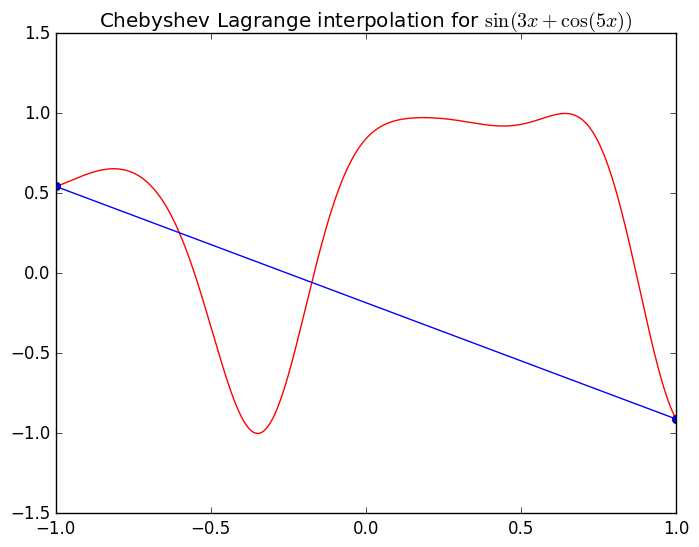

In [38]:
fig = figure()
x = linspace(-1,1,1000)

@manipulate for n in slider(1:100, value=1)
    withfig(fig) do
        plot(x, f.(x), "r-")
        
        xn = cos.(linspace(0,pi,n+1))
        yn = f.(xn)
        B = baryweights(xn)
        plot(xn, yn, "bo")
        plot(x, [lagrange(xn,yn,x,B) for x in x], "b-")
        ylim(-1.5,1.5)

        title(L"Chebyshev Lagrange interpolation for $\sin(3x + \cos(5x))$")
    end
end

Using this, in principle we could proceed as follows:

1. Compute `f(x)` at the Chebyshev points $x = \cos(k\pi/n)$

2. Compute the coefficients of the Lagrange polynomial through these points.

3. Integrate the Lagrange polynomial using elementary calculus.  This is our approxmate $\int f$.

Computing the coefficients seems like a pain, but it turns out that there are very efficient ways to solve this problem, with the help of FFTs, and the result is known as [Clenshaw–Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature).  

Just to see what the error *would* be, I will cheat: I will integrate our Lagrange interpolating polynomial numerically:

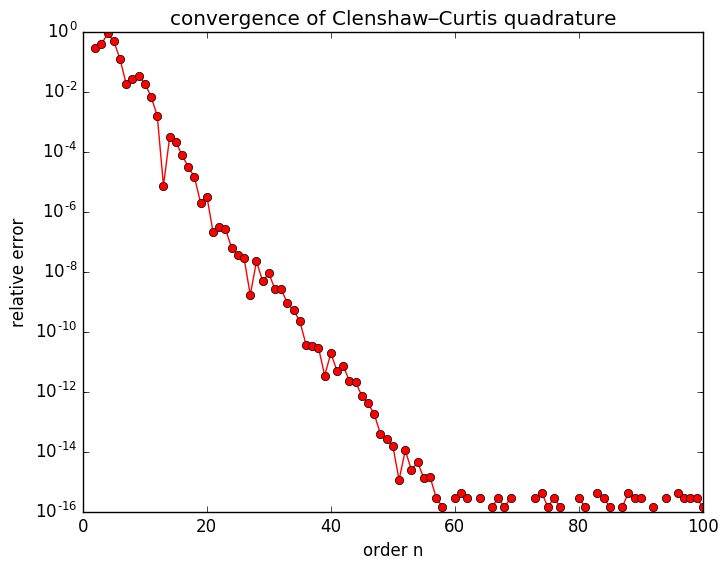

PyObject <matplotlib.text.Text object at 0x329962590>

In [39]:
exact = quadgk(f, -1, 1, reltol=1e-14)[1]
N = 2:100
cheb_err = Float64[]
for n in N
    xn = cos.(linspace(0,pi,n+1))
    yn = f.(xn)
    B = baryweights(xn)
    push!(cheb_err, abs(quadgk(x -> lagrange(xn,yn,x,B),-1,1, reltol=1e-14)[1] - exact) / exact)
end
semilogy(N, cheb_err, "ro-")
title("convergence of Clenshaw–Curtis quadrature")
xlabel("order n")
ylabel("relative error")

## Automated polynomial approximation: ApproxFun

There is a cool Julia package called [ApproxFun](https://github.com/JuliaApproximation/ApproxFun.jl) (inspired by the pioneering [chebfun software](http://www.chebfun.org/) for Matlab) that exploits the above convergence properties.

ApproxFun quickly builds an *exponentially convergent polynomial approximation* to any given smooth function.  Given this polynomial, you can quickly compute lots of things: integrals, roots, derivatives, even solutions to differential equations.  The basic idea is that **once you have a polynomial, all computations are easy**.

In [40]:
# Pkg.add("ApproxFun")
using ApproxFun

INFO: Recompiling stale cache file /Users/stevenj/.julia/lib/v0.5/StatsBase.ji for module StatsBase.
INFO: Recompiling stale cache file /Users/stevenj/.julia/lib/v0.5/ApproxFun.ji for module ApproxFun.


In [41]:
fp = Fun(f, -1..1) # compute a polynomial representation of f

Fun(Chebyshev(【-1.0,1.0】),[0.297427,-0.196523,-0.229403,-0.726359,-0.238029,0.23419,-0.194837,-0.087399,0.255925,0.0333333  …  -2.16713e-13,9.23418e-13,-1.78559e-13,-2.32581e-13,1.14512e-13,3.93432e-14,-4.42537e-14,6.18573e-17,1.30396e-14,-3.41889e-15])


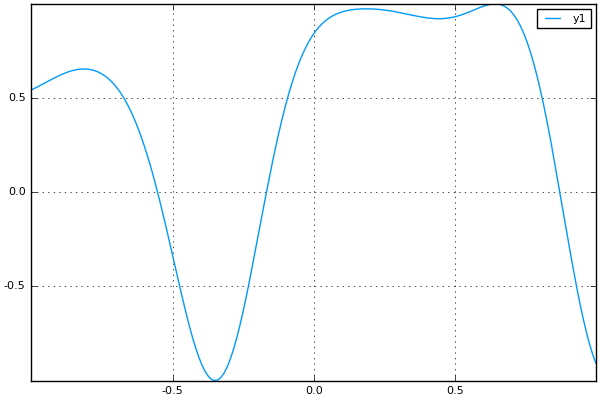

/Users/stevenj/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [42]:
import Plots
Plots.plot(fp)

In [43]:
sum(fp) # compute the integral

0.7841369931808353

In [44]:
sum(fp) - quadgk(f, -1,1, reltol=1e-15)[1]

-3.3306690738754696e-16

In [45]:
roots(fp)

3-element Array{Float64,1}:
 -0.552943
 -0.167412
  0.871854

Given a polynomial, we can quickly find all of its roots:


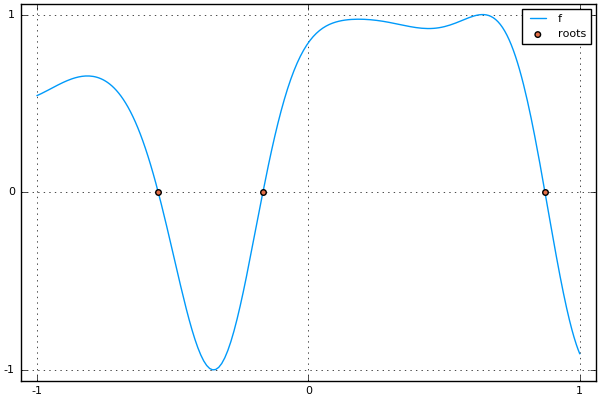

In [46]:
Plots.plot(fp, label="f")
Plots.plot!(roots(fp), zeros(roots(fp)), seriestype=:scatter, label="roots")

`fp'` is the derivative of `fp`, and with its roots we can find *all* the local maxima and minima of `f`:


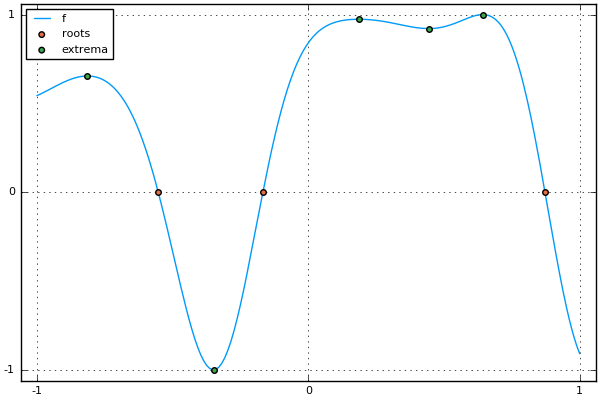

In [47]:
Plots.plot(fp, label="f")
Plots.plot!(roots(fp), zeros(roots(fp)), seriestype=:scatter, label="roots")
Plots.plot!(roots(fp'), fp(roots(fp')), seriestype=:scatter, label="extrema")

# Optimization

A common problem in many areas of engineering, science, finance, etcetera, is *optimization*: **minimize** (or maximize) some **objective function** $f(x)$ with respect to $n$ **design parameters** $x$ (typically in $\mathbb{R}^n$... optimizing [over integers](https://en.wikipedia.org/wiki/Integer_programming) is much harder), possibly subject to one or more **constraints**.

There are *many, many* algorithms for optimization.  Which one is best depends a lot on the problem: whether you want a global or a local minimum, whether the problem is [convex](https://en.wikipedia.org/wiki/Convex_optimization), whether you have constraints and what the constraints look like, whether the objective is smooth or noisy, and so on.  Choosing the right algorithm is important, because an **algorithm that takes advantage of the structure of your problem** can be orders of magnitude more efficient that an algorithm that does not.

## Global and local optimization

One especially difficult problem is [global optimization](https://en.wikipedia.org/wiki/Global_optimization) of objectives that have *multiple local minima*.

There are *no good algorithms* for this problem in general — it is easy to come up with global-optimization problems that take *arbitrarily long to solve*.  Worse, for an arbitrary function you have *no way of knowing when to stop*.  In practice, you keep looking for a better solution until you run out of patience.

The most famous global-optimization algorithms are probably [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm).  These algorithms are very general, easy to implement, and easy to parallelize.  They also have an evocative "natural analogy" to evolution, and probably this helps gives them a *disproportionate mindshare* among non-specialists.  Many specialists, however, view them as **methods of last resort**: because genetic algorithms assume virtually *nothing* about your problem, they can be *much slower* than methods that exploit some basic properties (e.g. continuity or smoothness).

The [Goldstein–Price function](https://www.sfu.ca/~ssurjano/goldpr.html) is a simple 2d test function with several local minima that is often used for global-optimization code:

In [48]:
goldsteinprice(x1, x2) =
    (1 + (x1 + x2 + 1)^2*(19 - 14x1 + 3x1^2 - 14x2 + 6x1*x2 + 3x2^2)) *
    (30 + (2x1 - 3x2)^2*(18 - 32x1 + 12x1^2 + 48x2 - 36x1*x2 + 27x2^2))

goldsteinprice (generic function with 1 method)

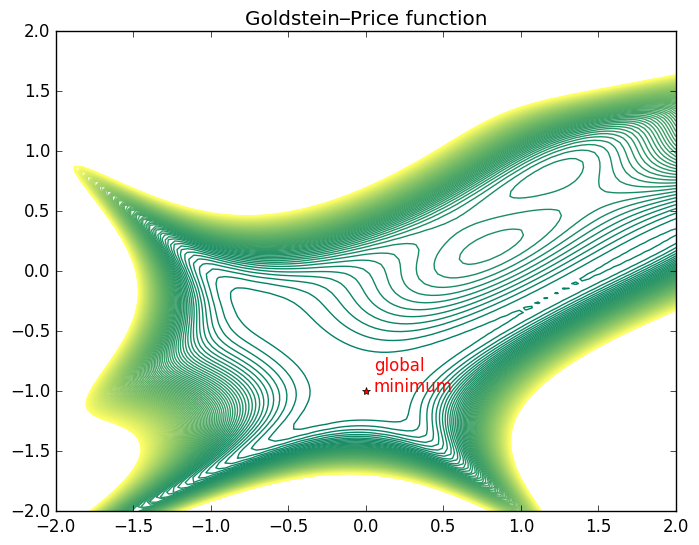

PyObject <matplotlib.text.Text object at 0x329be11d0>

In [49]:
x = linspace(-2,2,100)
contour(x', x, goldsteinprice.(x', x), levels=linspace(0,10^4,100), cmap="summer")
plot(0,-1, "r*")
text(0.05,-1, "global\nminimum", color="red")
title("Goldstein–Price function")

To explore the impact of several different optimization algorithms for this problem, I will use the [NLopt package](https://github.com/JuliaOpt/NLopt.jl).

To start with, let's try some genetic-like algorithms implemented in NLopt:

Interact.Options{:Dropdown,Symbol}(Signal{Symbol}(GN_ISRES, nactions=1),"",:GN_ISRES,"GN_ISRES",Interact.OptionDict(DataStructures.OrderedDict("GN_ISRES"=>:GN_ISRES,"GN_ESCH"=>:GN_ESCH,"GN_CRS2_LM"=>:GN_CRS2_LM),Dict(:GN_ESCH=>"GN_ESCH",:GN_CRS2_LM=>"GN_CRS2_LM",:GN_ISRES=>"GN_ISRES")),Any[],Any[],true,"horizontal")

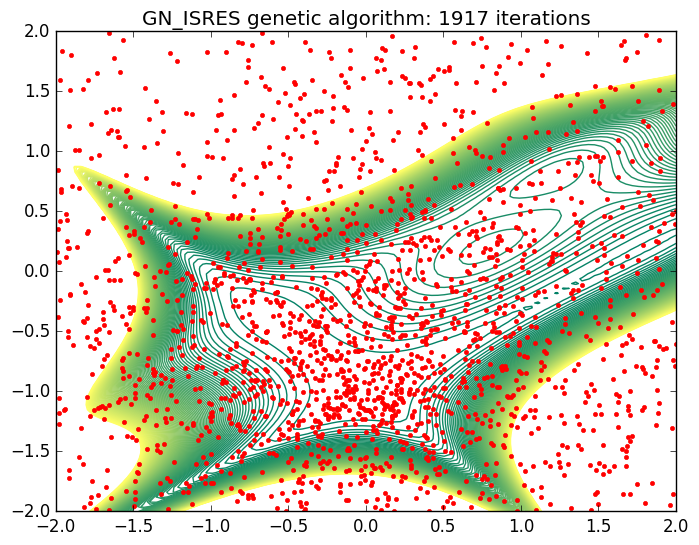

In [50]:
# install: Pkg.add("NLopt")
using NLopt

fig = figure()
@manipulate for alg in dropdown([:GN_ISRES, :GN_ESCH, :GN_CRS2_LM])
    withfig(fig) do
        opt = Opt(getfield(NLopt, alg), 2)
        lower_bounds!(opt, [-2,-2])
        upper_bounds!(opt, [+2,+2])
        visited = NTuple{2,Float64}[]
        min_objective!(opt, (x,g) -> begin push!(visited, (x[1],x[2])); goldsteinprice(x[1],x[2]); end)
        stopval!(opt, goldsteinprice(0,-1) + 0.1) # stop when within 0.1 of the global minimum
        maxeval!(opt, 10^4) # make sure we stop if it is not converging
        minf,minx,ret = optimize(opt, [2,0.5])

        x = linspace(-2,2,100)
        contour(x', x, goldsteinprice.(x', x), levels=linspace(0,10^4,100), cmap="summer")

        title(string("$alg genetic algorithm: ", length(visited), " iterations"))
        plot(getindex.(visited,1), getindex.(visited,2), "r.")
    end
end

Genetic algorithms bounce randomly around the domain, assuming essentially nothing about the objective function.

In contrast, a *determistic* global optimization algorithm in NLopt, which *assumes continuity* of the objective function, and can often work well in *low dimensions*, is the DIRECT ("dividing rectangles") algorithm:

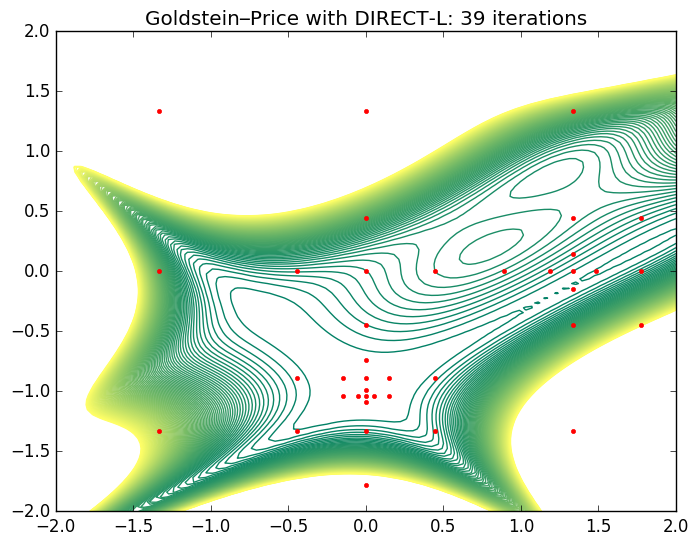

converged to [0.0,-0.987654] after 39 iterations


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32c826090>

In [56]:
opt = Opt(NLopt.GN_DIRECT_L, 2)
lower_bounds!(opt, [-2,-2])
upper_bounds!(opt, [+2,+2])
visited = NTuple{2,Float64}[]
min_objective!(opt, (x,g) -> begin push!(visited, (x[1],x[2])); goldsteinprice(x[1],x[2]); end)
stopval!(opt, goldsteinprice(0,-1) + 0.1) # stop when within 0.1 of the global minimum
maxeval!(opt, 10^4) # make sure we stop if it is not converging
minf,minx,ret = optimize(opt, [2,0.5])
println("converged to $minx after ", length(visited), " iterations")

x = linspace(-2,2,100)
contour(x', x, goldsteinprice.(x', x), levels=linspace(0,10^4,100), cmap="summer")

title("Goldstein–Price with DIRECT-L: $(length(visited)) iterations")
plot(getindex.(visited,1), getindex.(visited,2), "r.")

### Computing and exploiting derivatives

But our function is not only continuous, it is also *smooth*, and we can compute its derivative.  Although it is not hard to work out the derivative by hand, the [ForwardDiff](https://github.com/JuliaDiff/ForwardDiff.jl) package can *automatically differentiate* our function.

(There are various methods of automatic differentiation.  If you have a very complicated program, especially one that calls non-Julia library routines, you may end up having to work out derivatives yourself.  However, there are non-obvious ways to compute derivatives: by using [adjoint methods](http://math.mit.edu/~stevenj/18.336/adjoint.pdf), it turns out that one can compute the gradient with respect to an *arbitrary number of parameters* with about the same cost as computing the objective function *one extra time*.)

*Some* of NLopt's algorithms can exploit gradient information if it is provided.  They do this by passing a non-empty vector as the *second* argument of our objective: if this vector is non-empty, you are supposed to fill it with the gradient of the function at the current point.

In [52]:
using ForwardDiff

# ForwardDiff requires a function that takes a vector
goldsteinprice(x) = goldsteinprice(x[1],x[2])

const cfg2d = ForwardDiff.GradientConfig([1.0,2.0]) # configure for vector of 2 Float64s

# NLopt uses the second argument to get the gradient, if g is non-empty
function goldsteinprice(x::AbstractVector, g::AbstractVector)
    isempty(g) || ForwardDiff.gradient!(g, goldsteinprice, x, cfg2d)
    return goldsteinprice(x)
end

goldsteinprice (generic function with 3 methods)

Let's check that the gradient is zero at the global minimum (0,-1):

In [53]:
g = [1.0,1.0]
goldsteinprice([0.0,-1.0], g)
g

2-element Array{Float64,1}:
 0.0
 0.0

The easiest way to exploit derivative information is in [local optimization](https://en.wikipedia.org/wiki/Local_search_(optimization)), where we conceptually just "go downhill" from a given starting point to the nearest local minimum.

Local optimization can be very efficient, even with thousands or millions of parameters, but of course it may not find the global optimum if you don't give it a good starting guess.

A popular local-optimization algorithm is the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm.  It doesn't quite go "straight" downhill (which would be a steepest-descent algorithm).  Instead, it builds up some information about the *second* derivative of the objective as it goes along, and uses this to accelerate convergence:

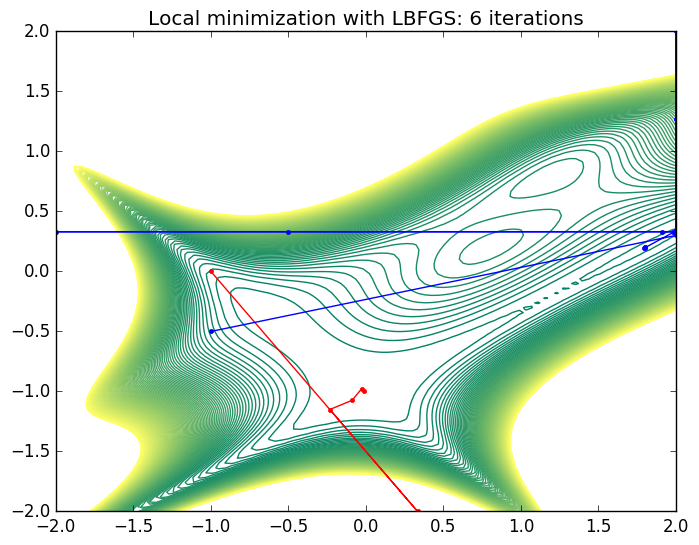

converged to [-0.0112188,-0.992984] after 6 iterations


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32d0e2990>

In [57]:
opt = Opt(NLopt.LD_LBFGS, 2)
lower_bounds!(opt, [-2,-2])
upper_bounds!(opt, [+2,+2])

visited = NTuple{2,Float64}[]
min_objective!(opt, (x,g) -> begin push!(visited, (x[1],x[2])); goldsteinprice(x,g); end)
stopval!(opt, goldsteinprice(0,-1) + 0.1) # stop when within 0.1 of the global minimum
maxeval!(opt, 10^4) # make sure we stop if it is not converging
xtol_abs!(opt, 1e-3) # stop if x stops changing by 1e-3
minf,minx,ret = optimize(opt, [-1,0])
println("converged to $minx after ", length(visited), " iterations")

x = linspace(-2,2,100)
contour(x', x, goldsteinprice.(x', x), levels=linspace(0,10^4,100), cmap="summer")

title("Local minimization with LBFGS: $(length(visited)) iterations")
plot(getindex.(visited,1), getindex.(visited,2), "r.-")

# try a different starting point:
visited = NTuple{2,Float64}[]
optimize(opt, [-1,-0.5])
plot(getindex.(visited,1), getindex.(visited,2), "b.-")

The most obvious way of getting the global optimum from a local-optimization algorithm is to just do local optimization from many random starting points.  This is known as a **multistart** algorithm, but random starting points can be inefficient: often, the same local minima will be found many times.

Instead, NLopt provides a multistart algorithm called MLSL, that does local optimization from many random starting points, plus some heuristics (with certain provable guarantees) to prevent it from rediscovering the same local optimum many times:

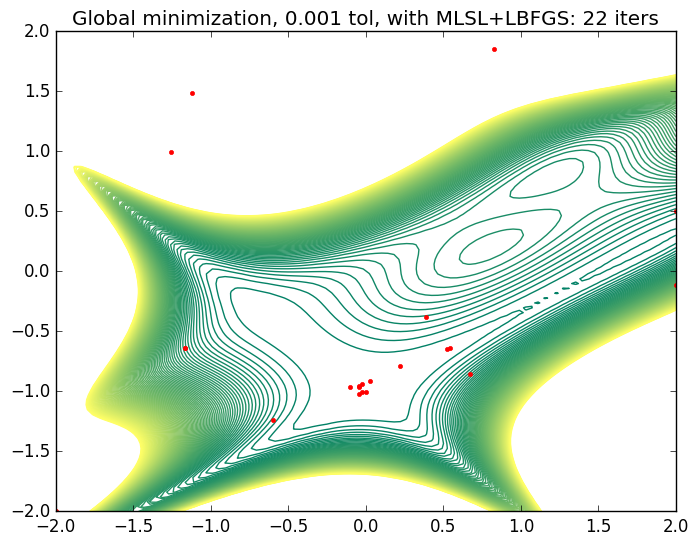

converged to [-0.00179626,-1.00052] after 22 iterations


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32d53a710>

In [59]:
opt = Opt(NLopt.GD_MLSL, 2)
lower_bounds!(opt, [-2,-2])
upper_bounds!(opt, [+2,+2])

visited = NTuple{2,Float64}[]
min_objective!(opt, (x,g) -> begin push!(visited, (x[1],x[2])); goldsteinprice(x,g); end)
stopval!(opt, goldsteinprice(0,-1) + 0.001) # stop when within 0.1 of the global minimum
maxeval!(opt, 10^4) # make sure we stop if it is not converging

# tell MLSL what local-optimization algorithm to use
opt_local = Opt(NLopt.LD_LBFGS, 2)
xtol_abs!(opt_local, 1e-4) # stop if x or f stops changing by 1e-3
ftol_abs!(opt_local, 1e-4)
local_optimizer!(opt, opt_local)

minf,minx,ret = optimize(opt, [2,0.5])
println("converged to $minx after ", length(visited), " iterations")

x = linspace(-2,2,100)
contour(x', x, goldsteinprice.(x', x), levels=linspace(0,10^4,100), cmap="summer")

title("Global minimization, 0.001 tol, with MLSL+LBFGS: $(length(visited)) iters")
plot(getindex.(visited,1), getindex.(visited,2), "r.")